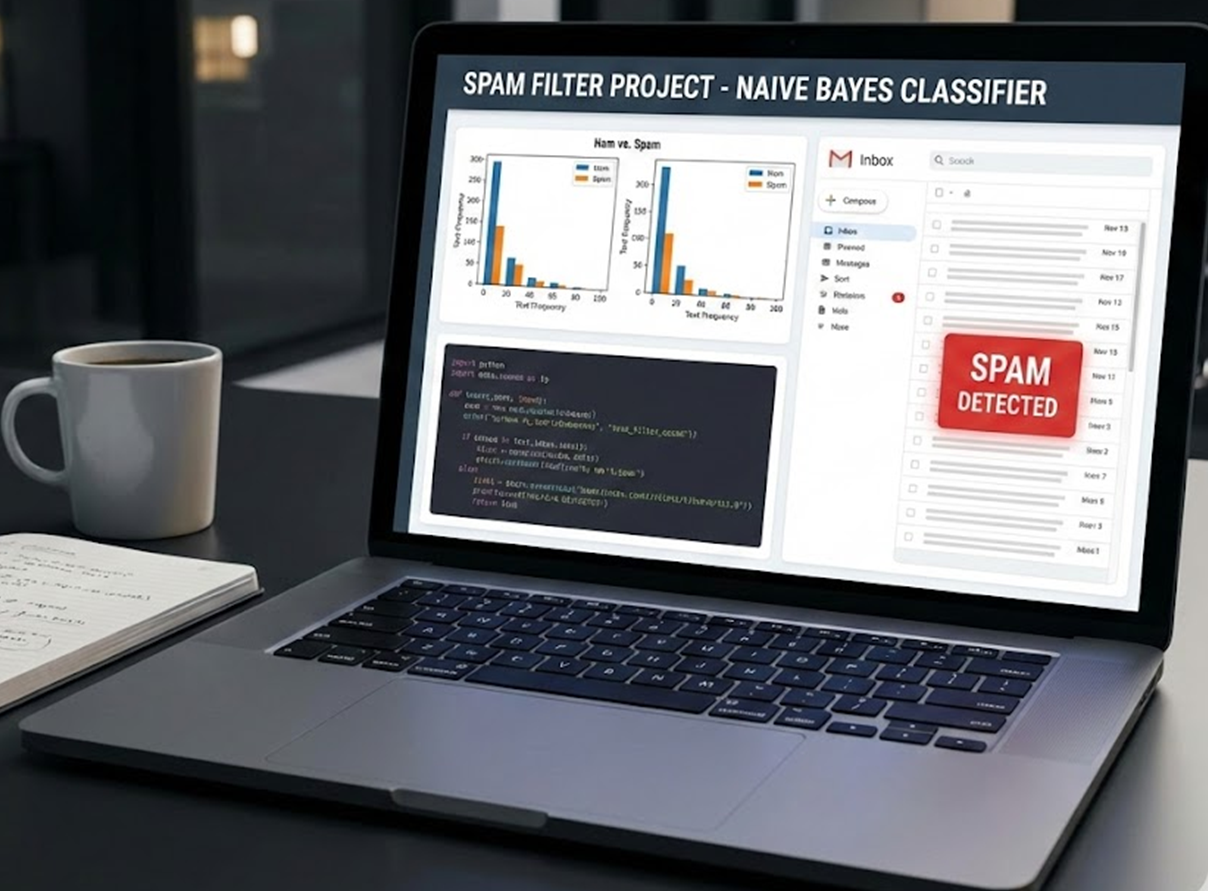

# Theoretical Steps: Building a Naive Bayes Classifier

In this module, we are building a **Multinomial Naive Bayes Classifier** from scratch to distinguish between "Spam" and "Ham" (non-spam) emails. We use the **Bag of Words** model, which looks at word frequency while ignoring grammar and sentence structure.

## Phase 1: Preprocessing (Converting Text to Numbers)
Before doing any math, we must convert raw text into a format the computer can understand.

1.  **Tokenization:** We split sentences into individual words (tokens).
2.  **Normalization:** We convert all words to lowercase so that "Free" and "free" are treated as the same word.
3.  **Filtering:** We remove punctuation and very short words (which often carry little meaning).

## Phase 2: Training (The "Learning" Phase)
Training a Naive Bayes model doesn't involve complex optimization like Neural Networks. Instead, it is simply **counting** to estimate probabilities.

### Step 1: Calculate the "Prior" Probabilities
The **Prior** ($P(Class)$) represents our baseline belief before seeing the content of the email. It answers the question: *"If I pick an email at random, what is the probability it is spam?"*

$$P(Spam) = \frac{\text{Number of Spam Emails}}{\text{Total Number of Emails}}$$

$$P(Ham) = \frac{\text{Number of Ham Emails}}{\text{Total Number of Emails}}$$

### Step 2: Calculate the "Likelihood" Probabilities
The **Likelihood** ($P(Word | Class)$) answers: *"If an email is Spam, what is the probability that it contains the word 'Money'?"*

We calculate this for every word in our vocabulary:

$$P(w_i | Spam) = \frac{\text{Count}(w_i \text{ in Spam})}{\text{Total Word Count in Spam}}$$

**The Problem of Zero:** If a word (e.g., "Bitcoin") never appears in our training data, its probability is 0. This would crash our model because multiplying by 0 wipes out all other information.

**The Solution (Laplace Smoothing):** We add a "dummy" count of 1 to every word to ensure no probability is ever zero.

$$P(w_i | Spam) = \frac{\text{Count}(w_i \text{ in Spam}) + 1}{\text{Total Word Count in Spam} + \text{Vocabulary Size}}$$

## Phase 3: Prediction (The "Testing" Phase)
To predict the class of a new, unseen email, we use **Bayes Theorem**.

### Step 3: Apply the "Naive" Assumption
Bayes Theorem tells us to calculate the **Posterior** probability:

$$P(Spam | \text{email}) \propto P(Spam) \times P(w_1 | Spam) \times P(w_2 | Spam) \dots$$

We call this "Naive" because we assume that words are **independent** of each other (e.g., the probability of seeing "Prince" is not affected by seeing "Nigeria"). While false in reality, this assumption simplifies the math enough to work well.

### Step 4: The Logarithm Trick
Multiplying many small probabilities (e.g., $0.001 \times 0.005 \times \dots$) results in **Underflow** (the number becomes too small for the computer to store).

To fix this, we use Logarithms. Since $\log(a \times b) = \log(a) + \log(b)$, we can **add** the logs instead of multiplying the probabilities.

**Final Score Calculation:**

$$\text{Score}(Spam) = \log(P(Spam)) + \sum_{i} \log(P(w_i | Spam))$$

$$\text{Score}(Ham) = \log(P(Ham)) + \sum_{i} \log(P(w_i | Ham))$$

### Step 5: Final Decision
We compare the two scores:
* If $\text{Score}(Spam) > \text{Score}(Ham) \rightarrow$ Predict **Spam**
* Otherwise $\rightarrow$ Predict **Ham**

In [1]:
import pandas as pd
import numpy as np
import re
import math

In [2]:
df = pd.read_csv('/content/drive/MyDrive/Linear_Algebra/Maths_Stats_AI/Unit3/emails.csv')

In [3]:
df.head()

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


In [5]:
# Define our cleaning function
def preprocess(text):
    text = str(text).lower()                 # Lowercase
    text = re.sub(r'[^\w\s]', '', text)      # Remove punctuation
    tokens = text.split()                    # Split by space
    return [w for w in tokens if len(w) > 2] # Keep words longer than 2 letters

print("Data loaded successfully!")
print(f"Total emails: {len(df)}")

Data loaded successfully!
Total emails: 5728


## Step 1: Separate the Data by Class
A Naive Bayes classifier works by comparing the patterns in "Spam" vs. the patterns in "Ham" (non-spam).
To do this, we first need to split our dataset into two separate piles.

In [6]:
# 1. Get the total number of emails
n_total = len(df)

# 2. Slice the dataframe to get text lists for each class
# df['spam'] == 1 means Spam
# df['spam'] == 0 means Ham
spam_texts = df[df['spam'] == 1]['text']
ham_texts = df[df['spam'] == 0]['text']

print(f"Number of Spam emails: {len(spam_texts)}")
print(f"Number of Ham emails:  {len(ham_texts)}")

Number of Spam emails: 1368
Number of Ham emails:  4360


## Step 2: Calculate the Priors (The Baseline)
The **Prior** ($P(Class)$) represents our baseline belief before seeing the content of the email. It answers the question: *"If I pick an email at random, what is the probability it is spam?"*

$$P(Spam) = \frac{\text{Number of Spam Emails}}{\text{Total Number of Emails}}$$

$$P(Ham) = \frac{\text{Number of Ham Emails}}{\text{Total Number of Emails}}$$

We also convert these to **Logarithms** in the code. Since probabilities are small numbers ($0 \le p \le 1$), multiplying them can cause numerical errors in computers. Adding logarithms is mathematically equivalent to multiplying probabilities but is much more stable.

In [7]:
# Calculate probability of each class
p_spam = len(spam_texts) / n_total
p_ham = len(ham_texts) / n_total

# Convert to Logarithms
log_prior_spam = math.log(p_spam)
log_prior_ham = math.log(p_ham)

print(f"Prior Probability of Spam: {p_spam:.4f} (Log: {log_prior_spam:.4f})")
print(f"Prior Probability of Ham:  {p_ham:.4f} (Log: {log_prior_ham:.4f})")

Prior Probability of Spam: 0.2388 (Log: -1.4320)
Prior Probability of Ham:  0.7612 (Log: -0.2729)


## Step 3: Build the "Bag of Words"
This is the core "training" step. We don't use complex optimization; we just **count**.
We need to answer: *How many times does the word 'free' appear in Spam emails vs. Ham emails?*

We will build:
1. `vocab`: A list of every unique word we have ever seen.
2. `spam_counts`: A dictionary mapping words to their frequency in Spam.
3. `ham_counts`: A dictionary mapping words to their frequency in Ham.

In [8]:
# Initialize our containers
vocab = set()
spam_counts = {}
ham_counts = {}

# We also need to keep track of the TOTAL number of words in each class
# This will be the denominator in our probability fraction later.
spam_total_words = 0
ham_total_words = 0

print("Counting words in SPAM emails...")
for text in spam_texts:
    words = preprocess(text)
    for w in words:
        vocab.add(w)
        spam_counts[w] = spam_counts.get(w, 0) + 1
        spam_total_words += 1

print("Counting words in HAM emails...")
for text in ham_texts:
    words = preprocess(text)
    for w in words:
        vocab.add(w)
        ham_counts[w] = ham_counts.get(w, 0) + 1
        ham_total_words += 1

print("\n--- Training Complete ---")
print(f"Total Unique Words (Vocabulary Size): {len(vocab)}")
print(f"Total Words in Spam buckets: {spam_total_words}")
print(f"Total Words in Ham buckets:  {ham_total_words}")

Counting words in SPAM emails...
Counting words in HAM emails...

--- Training Complete ---
Total Unique Words (Vocabulary Size): 36740
Total Words in Spam buckets: 219276
Total Words in Ham buckets:  832757


In [9]:
spam_counts

{'subject': 1574,
 'naturally': 9,
 'irresistible': 4,
 'your': 3730,
 'corporate': 54,
 'identity': 88,
 'really': 93,
 'hard': 57,
 'recollect': 25,
 'company': 805,
 'the': 8975,
 'market': 284,
 'full': 152,
 'suqgestions': 14,
 'and': 6517,
 'information': 740,
 'isoverwhelminq': 7,
 'but': 449,
 'good': 212,
 'catchy': 24,
 'logo': 196,
 'stylish': 15,
 'statlonery': 15,
 'outstanding': 54,
 'website': 465,
 'will': 1429,
 'make': 496,
 'task': 27,
 'much': 192,
 'easier': 42,
 'not': 1382,
 'promise': 60,
 'that': 1896,
 'havinq': 9,
 'ordered': 44,
 'iogo': 26,
 'automaticaily': 5,
 'become': 132,
 'world': 182,
 'ieader': 16,
 'isguite': 13,
 'ciear': 9,
 'without': 198,
 'products': 173,
 'effective': 100,
 'business': 844,
 'organization': 42,
 'practicable': 24,
 'aim': 26,
 'hotat': 23,
 'nowadays': 24,
 'marketing': 275,
 'efforts': 74,
 'more': 727,
 'here': 770,
 'list': 392,
 'clear': 66,
 'benefits': 58,
 'creativeness': 24,
 'hand': 82,
 'made': 242,
 'original': 83,

## Step 4: Inspecting What We Learned
Before we make predictions, let's look at what our model actually "knows".
We can check the counts for specific words to see if the model captures reality.

In [30]:
# Let's test a few words to see their counts
test_words = ['money', 'meeting', 'project', 'free']

print(f"{'Word':<15} | {'Spam Count':<10} | {'Ham Count':<10}")
print("-" * 45)

for w in test_words:
    s_count = spam_counts.get(w, 0)
    h_count = ham_counts.get(w, 0)
    print(f"{w:<15} | {s_count:<10} | {h_count:<10}")

Word            | Spam Count | Ham Count 
---------------------------------------------
money           | 662        | 113       
meeting         | 13         | 1772      
project         | 76         | 997       
free            | 606        | 530       


### Step 3: Apply the "Naive" Assumption
Bayes Theorem tells us to calculate the **Posterior** probability:

$$P(Spam | \text{email}) \propto P(Spam) \times P(w_1 | Spam) \times P(w_2 | Spam) \dots$$

We call this "Naive" because we assume that words are **independent** of each other (e.g., the probability of seeing "Prince" is not affected by seeing "Nigeria"). While false in reality, this assumption simplifies the math enough to work well.

### Step 4: The Logarithm Trick
Multiplying many small probabilities (e.g., $0.001 \times 0.005 \times \dots$) results in **Underflow** (the number becomes too small for the computer to store).

To fix this, we use Logarithms. Since $\log(a \times b) = \log(a) + \log(b)$, we can **add** the logs instead of multiplying the probabilities.

**Final Score Calculation:**

$$\text{Score}(Spam) = \log(P(Spam)) + \sum_{i} \log(P(w_i | Spam))$$

$$\text{Score}(Ham) = \log(P(Ham)) + \sum_{i} \log(P(w_i | Ham))$$


### Step 5: Final Decision
We compare the two scores:
* If $\text{Score}(Spam) > \text{Score}(Ham) \rightarrow$ Predict **Spam**
* Otherwise $\rightarrow$ Predict **Ham**


In [10]:
def predict_email(text):
    words = preprocess(text)

    # 1. Start with the Priors
    spam_score = log_prior_spam
    ham_score = log_prior_ham

    vocab_size = len(vocab)

    for w in words:
        # 2. Get counts for this word (default to 0 if not found)
        s_count = spam_counts.get(w, 0)
        h_count = ham_counts.get(w, 0)

        # 3. Calculate Likelihoods (with Laplace Smoothing +1)
        p_w_spam = (s_count + 1) / (spam_total_words + vocab_size)
        p_w_ham = (h_count + 1) / (ham_total_words + vocab_size)

        # 4. Add Logs to the score
        spam_score += math.log(p_w_spam)
        ham_score += math.log(p_w_ham)

    print(f"Spam Score: {spam_score:.2f}")
    print(f"Ham Score:  {ham_score:.2f}")

    if spam_score > ham_score:
        return "SPAM"
    else:
        return "HAM"

## Step 6: Testing the Classifier
Now we can type in our own custom emails to see if the math actually works!

In [13]:
# Example 1: A suspicious email
# email_1 = "Congratulations! You have won a free ticket. Click here to claim your prize."
email_1 = "You are a WINNER!!! Win big prizes now! Claim your free reward today. Win cash instantly. Limited time offer."

# Example 2: A normal work email
email_2 = "Track Your Personal Loan Status,Your verification for Bajaj Personal loan application for Rs. 5,00,000 Is In pending. Please check and update by Using the Link Below : http://po9.in/c2f41vv1gi Reference ID:7932632"

print("--- Test Case 1 ---")
print(f"Email: {email_1}")
print(predict_email(email_1))

print("\n--- Test Case 2 ---")
print(f"Email: {email_2}")
print(predict_email(email_2))

--- Test Case 1 ---
Email: You are a WINNER!!! Win big prizes now! Claim your free reward today. Win cash instantly. Limited time offer.
Spam Score: -136.11
Ham Score:  -154.08
SPAM

--- Test Case 2 ---
Email: Track Your Personal Loan Status,Your verification for Bajaj Personal loan application for Rs. 5,00,000 Is In pending. Please check and update by Using the Link Below : http://po9.in/c2f41vv1gi Reference ID:7932632
Spam Score: -206.01
Ham Score:  -217.83
SPAM


### Scikit learn implementation

In [14]:
import pandas as pd
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

# 1. Load Data
# df = pd.read_csv('emails.csv')

# # 2. Define Custom Preprocessing (Same as manual version)
# def preprocess(text):
#     text = str(text).lower()                 # Lowercase
#     text = re.sub(r'[^\w\s]', '', text)      # Remove punctuation
#     tokens = text.split()                    # Split by space
#     return [w for w in tokens if len(w) > 2] # Keep words longer than 2 letters

# 3. Prepare Data
# We tell CountVectorizer to use OUR function instead of its default
vectorizer = CountVectorizer(analyzer=preprocess)

# Transform the ENTIRE dataset
X_all = vectorizer.fit_transform(df['text'])
y_all = df['spam']

# 4. Train Model (on everything)
model = MultinomialNB()
model.fit(X_all, y_all)

# 5. Verify Training
# Check accuracy on the training data itself
train_accuracy = model.score(X_all, y_all)
# print(f"Model trained on {len(df)} emails.")
# print(f"Training Accuracy: {train_accuracy * 100:.2f}%")

# 6. Predict on New Data
new_emails = [
    email_1,email_2
]

# Transform using the TRAINED vectorizer
new_emails_vectorized = vectorizer.transform(new_emails)
predictions = model.predict(new_emails_vectorized)

print("\n--- Predictions ---")
for text, label in zip(new_emails, predictions):
    result = "Spam" if label == 1 else "Ham"
    print(f"'{text}' -> {result}")


--- Predictions ---
'You are a WINNER!!! Win big prizes now! Claim your free reward today. Win cash instantly. Limited time offer.' -> Spam
'Track Your Personal Loan Status,Your verification for Bajaj Personal loan application for Rs. 5,00,000 Is In pending. Please check and update by Using the Link Below : http://po9.in/c2f41vv1gi Reference ID:7932632' -> Spam
